In [4]:
pip install pydicom nibabel numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pydicom
import nibabel as nib
import numpy as np

dicom_folder = '/NFS/Wendy/新增資料夾/DICOM_DTI'
output_file = 'output_dti.nii.gz'
dicom_files = [os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if f.endswith(".IMA")]

dicom_slices = [pydicom.dcmread(f, force=True) for f in dicom_files]
dicom_slices.sort(key=lambda x: int(x.InstanceNumber))
image_data = np.stack([s.pixel_array for s in dicom_slices], axis=-1)

voxel_spacing = (
    float(dicom_slices[0].PixelSpacing[0]),  # x spacing
    float(dicom_slices[0].PixelSpacing[1]),  # y spacing
    float(dicom_slices[0].SliceThickness))   # z spacing
affine = np.diag(voxel_spacing + (1.0,))

nifti_image = nib.Nifti1Image(image_data, affine)

# 儲存為壓縮的 NIfTI 檔案
nib.save(nifti_image, output_file)
print(f"NIfTI file saved as: {output_file}")



AttributeError: Unable to decode the pixel data as the dataset's 'file_meta' has no (0002,0010) 'Transfer Syntax UID' element

In [4]:
import os

#os.environ["PATH"] += "C:\\Users\\beiiw\\Downloads\\dcm2niix_win"
dcm2niix_path = "C:/Users/beiiw/Downloads/NITRC-multi-file-downloads/MRIcroGL_windows/MRIcroGL/Resources/dcm2niix.exe"

dicom_folder = 'DICOM_DTI'
output_folder = 'NII'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

!"{dcm2niix_path}" -z y -o {output_folder} {dicom_folder}

/bin/bash: line 1: C:/Users/beiiw/Downloads/NITRC-multi-file-downloads/MRIcroGL_windows/MRIcroGL/Resources/dcm2niix.exe: No such file or directory


In [5]:
!dcm2niix --version

/bin/bash: line 1: dcm2niix: command not found


In [ ]:
#DTI分析，截b=0的volume

import nibabel as nib

nii_file = "/NFS/Wendy/homework/HW2/IXI-T1/*.nii.gz"
img = nib.load(nii_file)
data = img.get_fdata()

volume_1 = data[:, :, :, 0]  

print("單一體積形狀:", volume_1.shape)


In [15]:
import nibabel as nib
import numpy as np
from dipy.io.image import load_nifti
from dipy.reconst.dti import TensorModel
from dipy.core.gradients import gradient_table

data_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.nii.gz'  
bvals_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bval'
bvecs_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bvec'
img, affine = load_nifti(data_file)

# 梯度(bvals, bvecs)
gtab = gradient_table(bvals_file, bvecs_file)

model = TensorModel(gtab)
fit = model.fit(img)
fa = fit.fa  # FA
adc = fit.md  #ADC

nib.save(nib.Nifti1Image(fa.astype(np.float32), affine), 'FA_map.nii.gz')
nib.save(nib.Nifti1Image(adc.astype(np.float32), affine), 'ADC_map.nii.gz')
print("successful")


successful


計算得到的 ADC 值: nan mm²/s


/tmp/ipykernel_554495/1383478962.py:28: RuntimeWarning: divide by zero encountered in log
  log_roi = np.log(roi)


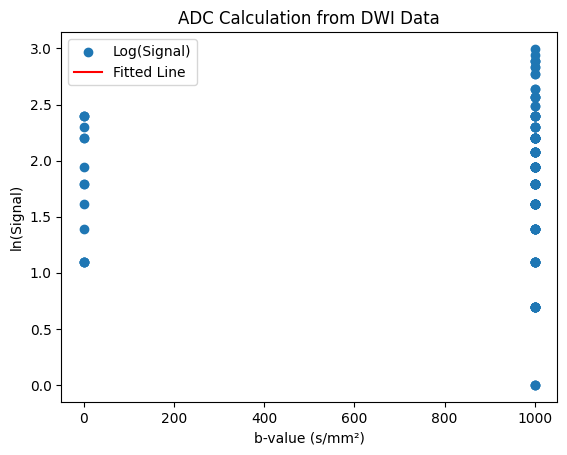

In [16]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

dwi_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.nii.gz'
bval_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bval'
bvec_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bvec' 

img = nib.load(dwi_file)
data = img.get_fdata()

bvals = np.loadtxt(bval_file)
bvecs = np.loadtxt(bvec_file)

x, y, z, n = data.shape


log_roi = np.log(roi)
slope, intercept = np.polyfit(bvals, log_roi, 1)

# 提取斜率
ADC_value = -slope

print(f"計算得到的 ADC 值: {ADC_value:.4e} mm²/s")

plt.scatter(bvals, log_roi, label="Log(Signal)")
plt.plot(bvals, slope * bvals + intercept, label="Fitted Line", color='red')
plt.xlabel("b-value (s/mm²)")
plt.ylabel("ln(Signal)")
plt.title("ADC Calculation from DWI Data")
plt.legend()
plt.show()


/tmp/ipykernel_554495/2512495713.py:30: RuntimeWarning: divide by zero encountered in log
  slope, _ = np.polyfit(bvals, np.log(S), 1)


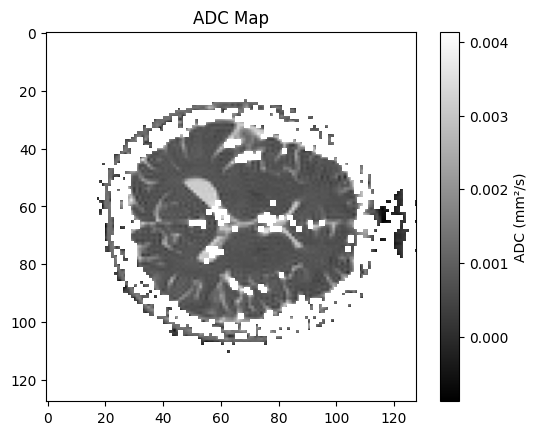

In [17]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

dwi_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.nii.gz'  # NIfTI 格式 DWI 影像
bval_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bval'  # bvals 檔案
bvec_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bvec'  # bvecs 檔案

img = nib.load(dwi_file)
data = img.get_fdata()
bvals = np.loadtxt(bval_file)
bvecs = np.loadtxt(bvec_file)

x, y, z, n_bvals = data.shape  # 影像尺寸 (空間 x, y, z, b 值數量)

S0 = data[:, :, :, bvals == 0].mean(axis=-1)
log_signal = np.log(data + 1e-6)
ADC_map = np.zeros((x, y, z))


for i in range(x):
    for j in range(y):
        for k in range(z):

            S = data[i, j, k, :]
            if S[0] > 0:  # 確保有有效訊號
                slope, _ = np.polyfit(bvals, np.log(S), 1)
                ADC_map[i, j, k] = -slope 

adc_img = nib.Nifti1Image(ADC_map, img.affine)
nib.save(adc_img, "ADC_map2.nii")

plt.imshow(ADC_map[:, :, data.shape[2] // 2], cmap="gray")
plt.title("ADC Map")
plt.colorbar(label="ADC (mm²/s)")
plt.show()


In [47]:
print( data.shape[2] // 2)

30


/tmp/ipykernel_554495/1397917372.py:25: RuntimeWarning: divide by zero encountered in divide
  ADC_map = -np.log(S1000 / S0) / 1000  # 記得這裡 b = 1000
/tmp/ipykernel_554495/1397917372.py:25: RuntimeWarning: invalid value encountered in divide
  ADC_map = -np.log(S1000 / S0) / 1000  # 記得這裡 b = 1000


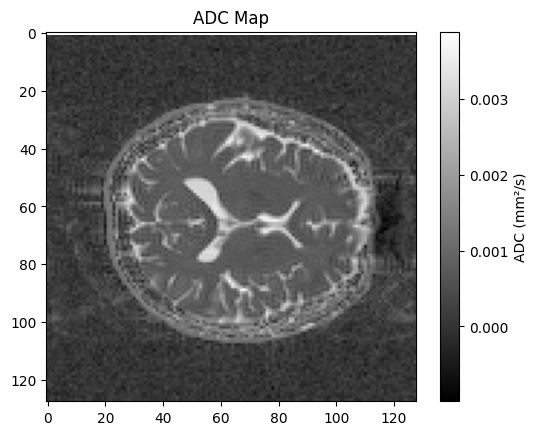

In [19]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

dwi_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.nii.gz'  # NIfTI 格式 DWI 影像
bval_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bval'  # bvals 檔案
bvec_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bvec'  # bvecs 檔案

img = nib.load(dwi_file)
data = img.get_fdata()

bvals = np.loadtxt(bval_file)
bvecs = np.loadtxt(bvec_file)

b0_indices = np.where(bvals == 0)[0]  # b = 0 的 index
b1000_indices = np.where(bvals == 1000)[0]  # b = 1000 的 index

# 計算 b=0 和 b=1000 的平均訊號
S0 = data[:, :, :, b0_indices].mean(axis=-1)  # b = 0 的平均訊號
S1000 = data[:, :, :, b1000_indices].mean(axis=-1)  # b = 1000 的平均訊號

ADC_map = -np.log(S1000 / S0) / 1000  # 記得這裡 b = 1000

adc_img = nib.Nifti1Image(ADC_map, img.affine)
nib.save(adc_img, 'ADC_map3.nii')

plt.imshow(ADC_map[:, :, data.shape[2] // 2], cmap="gray")
plt.title("ADC Map")
plt.colorbar(label="ADC (mm²/s)")
plt.show()


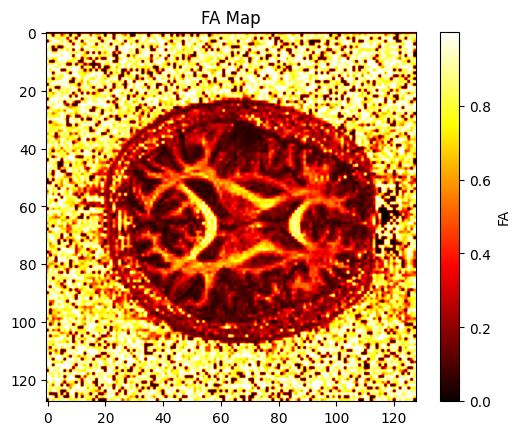

In [20]:
from dipy.reconst.dti import TensorModel
from dipy.core.gradients import gradient_table

# 計算梯度表
gtab = gradient_table(bvals, bvecs)

# 擴散張量模型
tensor_model = TensorModel(gtab)

# 擬合 DTI 模型
tensor_fit = tensor_model.fit(data)

# 提取各種 DTI 指標
FA_map = tensor_fit.fa  # 各向異性分數
MD_map = tensor_fit.md  # 平均擴散
RD_map = tensor_fit.rd  # 徑向擴散

fa_img = nib.Nifti1Image(FA_map, img.affine)
nib.save(fa_img, 'FA_map.nii')

md_img = nib.Nifti1Image(MD_map, img.affine)
nib.save(md_img, 'MD_map.nii')

rd_img = nib.Nifti1Image(RD_map, img.affine)
nib.save(rd_img, 'RD_map.nii')

plt.imshow(FA_map[:, :, data.shape[2] // 2], cmap="hot")
plt.title("FA Map")
plt.colorbar(label="FA")
plt.show()



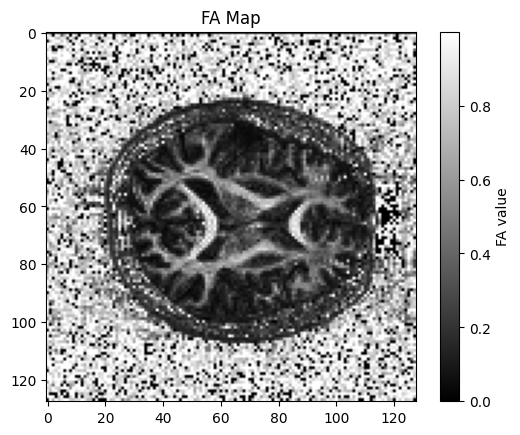

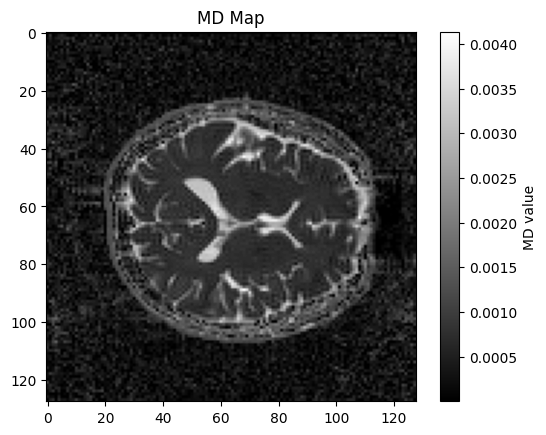

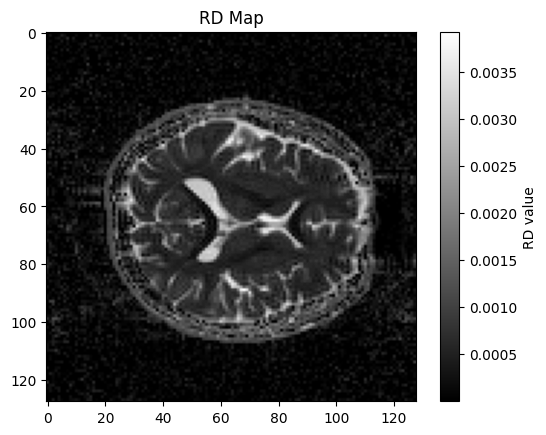

In [49]:
plt.imshow(FA_map[:, :, data.shape[2] // 2], cmap="gray")
plt.title("FA Map")
plt.colorbar(label="FA value")
plt.show()

plt.imshow(MD_map[:, :, data.shape[2] // 2], cmap="gray")
plt.title("MD Map")
plt.colorbar(label="MD value")
plt.show()

plt.imshow(RD_map[:, :, data.shape[2] // 2], cmap="gray")
plt.title("RD Map")
plt.colorbar(label="RD value")
plt.show()

In [31]:
!bet DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.nii.gz dwi_brain.nii.gz -m -f 0.3

/bin/bash: line 1: bet: command not found


In [35]:
print(bvecs)

[[ 0.00000e+00 -2.03380e-01  1.96989e-01  4.01933e-01 -4.04006e-01
  -2.01916e-01 -8.53648e-01 -7.31774e-01 -4.06919e-01 -7.32818e-01
  -6.50072e-01 -3.21704e-01 -3.24387e-01 -6.49779e-01 -9.78466e-01
  -8.54223e-01  7.32140e-04  1.87974e-03  6.53383e-01  3.29100e-01
   1.97821e-01  2.03415e-01  6.50950e-01  3.23642e-01  1.99800e-01
   4.04006e-01  7.31983e-01  7.29210e-01  8.52912e-01  8.56941e-01
   9.79176e-01  0.00000e+00 -2.03380e-01  1.96989e-01  4.01933e-01
  -4.04006e-01 -2.01916e-01 -8.53648e-01 -7.31774e-01 -4.06919e-01
  -7.32818e-01 -6.50072e-01 -3.21704e-01 -3.24387e-01 -6.49779e-01
  -9.78466e-01 -8.54223e-01  7.32140e-04  1.87974e-03  6.53383e-01
   3.29100e-01  1.97821e-01  2.03415e-01  6.50950e-01  3.23642e-01
   1.99800e-01  4.04006e-01  7.31983e-01  7.29210e-01  8.52912e-01
   8.56941e-01  9.79176e-01  0.00000e+00 -2.03380e-01  1.96989e-01
   4.01933e-01 -4.04006e-01 -2.01916e-01 -8.53648e-01 -7.31774e-01
  -4.06919e-01 -7.32818e-01 -6.50072e-01 -3.21704e-01 -3.24387

TypeError: Image data of dtype object cannot be converted to float

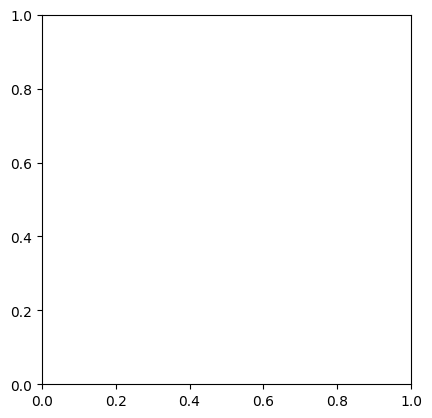

In [44]:
import nibabel as nib
import numpy as np
from dipy.io.image import load_nifti
from dipy.reconst.dti import TensorModel
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt

dwi_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.nii.gz'  # NIfTI 格式 DWI 影像
bval_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bval'  # bvals 檔案
bvec_file = 'NII/DICOM_DTI_ep2d_diff_iso2_mddw_30_p3_20130607201102_3.bvec'  # bvecs 檔案

img, affine = load_nifti(dwi_file)

# 建立梯度表 (bvals, bvecs)
gtab = gradient_table(bval_file, bvec_file)

# 計算 DTI 指標
ten_model = TensorModel(gtab)
ten_fit = ten_model.fit(img)

fa = ten_fit.fa 
adc = ten_fit.md 

nib.save(nib.Nifti1Image(fa.astype(np.float32), affine), 'FA_map4.nii.gz')
nib.save(nib.Nifti1Image(adc.astype(np.float32), affine), 'ADC_map4.nii.gz')
plt.imshow(nib.Nifti1Image(fa.astype(np.float32), affine))
plt.title('FA_map')
pit.show


In [39]:
!pip install dipy

In [43]:
!run_first_all -i DICOM_DTI_MPRAGE_Sag_1mm_iso_g2_20130607201102_2.nii -o subcortical_segmentation

/bin/bash: line 1: run_first_all: command not found


In [51]:
import nibabel as nib
import numpy as np

fa_img = nib.load('FA_map.nii.gz')
roi_mask = nib.load('brain_extracted_mask.nii.gz')

fa_data = fa_img.get_fdata()
roi_data = roi_mask.get_fdata()

roi_fa_values = fa_data[roi_data > 0] 
mean_fa = np.mean(roi_fa_values)
print("平均 FA 值:", mean_fa)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 128 but corresponding boolean dimension is 192

In [56]:
import nibabel as nib

img = nib.load('DICOM_DTI_MPRAGE_Sag_1mm_iso_g2_20130607201102_2.nii.gz')
mask = nib.load('brain_extracted_mask.nii.gz')
brain = nib.load('brain_extracted.nii.gz')
adc_img = nib.load('ADC_map2.nii')

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("FA_map shape", fa_img.shape)
print("brian shape", brain.shape)
print("ADC_map shape", adc_img.shape)

Image shape: (192, 256, 256)
Mask shape: (192, 256, 256)
FA_map shape (128, 128, 61)
brian shape (192, 256, 256)
ADC_map shape (128, 128, 61)
